In [1]:
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_validate
import lightgbm as lgbm

from settings import file_names

# Datasets

In [2]:
df_reviews = pd.read_csv(file_names['toronto_reviews_without_text'])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

In [3]:
df_tips = pd.read_json(file_names['tip'], encoding='utf-8', lines=True)
df_tips = df_tips.loc[df_tips['user_id'].isin(df_users.user_id.unique()) & df_tips['business_id'].isin(df_biz.business_id.unique())]
print('Number of Tips: ', df_tips.shape[0])
df_tips.head(3)

Number of Tips:  33192


,user_id,business_id,text,date,compliment_count
7,CaFbX7topxdLpBJ_SNDfGQ,r49iBfbnfoK7yt4rdsL_7g,Hands down best AYCE in town! Love it!,2016-01-05 06:39:33,0
10,8zXgNCkusOHMwh5Tj_8yCQ,qrSsS0pk7SL67MP5nN8tlg,More parking in the back of the restaurant,2013-12-22 05:10:12,0
13,oIHhfloe5VQamDFDB2dr1Q,wZhB4U003eg2GQ-F7D2D4A,When you receive the bag of seafood tie it up ...,2016-08-12 22:18:07,0


In [4]:
print('Number of reviews: ',df_reviews.shape[0])
print('Ratings describe: ', df_reviews['rating'].describe())
df_reviews.head(3)



Number of reviews:  228816
Ratings describe:  count    228816.000000
mean          3.643093
std           1.139687
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,business_id,rating,date
0,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1.0,2012-07-16 00:37:14
1,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
2,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4.0,2015-04-01 13:31:35


In [5]:
print('Number of users: ',df_users.shape[0])
df_users.head(3)

Number of users:  18804


,user_id,friends
0,gvXtMj3XuPr0xHjgmlmtng,"CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA..."
1,pU6GoRTcl1rIOi6zMynjog,"SwK2Oo8sjOH0yXYVoyjJwQ, 1LpChUg-0EqRKRKzL4ogYA..."
2,AsYMm_O4H-mwmWbmeACDHw,"w-bVY-dhpvnNs8W3BTTgAA, o_OEO0ES7oywPqENQR0f3A..."


In [6]:
print('Number of businesses: ',df_biz.shape[0])
df_biz.head(3)

Number of businesses:  7965


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas..."
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve..."
2,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ..."


# Collaborative Filtering - Rating Prediction

In [7]:
from surprise import SVD, SVDpp, CoClustering, SlopeOne, KNNBasic, KNNWithZScore

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate as surprise_cv, GridSearchCV as surprise_grid_search_cv, train_test_split as surprise_test_train_split

df_surprise = df_reviews[['business_id', 'user_id', 'rating']]
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_surprise, reader)
algo = SVD()

# surprise_cv(algo, data, measures=['RMSE', 'MAE', 'fcp'], cv=3, verbose=3, n_jobs=3)

In [8]:
trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.5782
MAE:  0.8192
0.5782065651481083 0.8191626206063986


In [9]:
predictions[:2]

[Prediction(uid='f5O7v_X_jCg2itqacRfxhg', iid='yfhchNS9zMnnIGYnRC218g', r_ui=3.0, est=4.274534071622122, details={'was_impossible': False}),
 Prediction(uid='-av1lZI1JDY_RZN2eTMnWg', iid='fIqgMebiSjVb0g27OqWBDw', r_ui=2.0, est=4.107149853350335, details={'was_impossible': False})]

# Baseline Binary Prediction - Collaborative Filtering

#### Build input data for recommender:

In [10]:
from networkx.algorithms import bipartite
from graph import *

g_bi = make_user_business_bipartite_graph(weighted=False, minimum_rating=0)

In [11]:
users = {n for n, d in g_bi.nodes(data=True) if d['bipartite']==0}
businesses = set(g_bi) - users
print(len(users), len(businesses), len(set(g_bi)))

18802 7860 26662


In [12]:
def get_binary_df(graph):
    df_users = pd.read_csv(file_names['toronto_users'])
    
    users = {n for n, d in graph.nodes(data=True) if d['bipartite']==0}
    businesses = set(graph) - users
    
    binary_data = bipartite.biadjacency_matrix(graph, users, column_order=businesses).todense()
    df_binary = pd.DataFrame(binary_data, columns=businesses)
    df_binary['user_id'] = users
    df_binary = pd.melt(df_binary, id_vars='user_id')
    df_binary.rename({'variable':'business_id', 'value':'has_reviewed'}, axis='columns', inplace=True)
    # df_binary.set_index(list(graph.nodes()))
    return df_binary

In [13]:
df_binary = get_binary_df(g_bi)

In [14]:
def negative_sampling(df, ratio_zeros_on_ones : float):
    '''
    creates a dataframe for training of recommender. 
    Only keeps a fractions of non-positive labels, as input matrix is extremely sparse.
    params: 
    df: pd.DataFrame containing user_id, business_id, and binary label has_reviewed
    '''
    df_zeros = df_binary.loc[df_binary['has_reviewed'] == 0]
    df_ones = df_binary.loc[df_binary['has_reviewed'] != 0]
    df_zeros = df_zeros.sample(n=int(df_ones.shape[0]*ratio_zeros_on_ones))
    return pd.concat([df_zeros, df_ones]).sample(frac=1).reset_index(drop=True)

#### Build, train and evaluate recommender:

In [15]:
reader = Reader(rating_scale=(0, 1))

data = negative_sampling(df_binary, 1)
print(data.shape)
data = Dataset.load_from_df(data, reader)

(441858, 3)


In [16]:
algo = SVDpp(n_factors=10, n_epochs=30, init_mean=0.5)

trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)

predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.6849
MAE:  0.2815
0.6848923943722204 0.2815218792446943


#### Precision of the recommender: Percentage of Top 1 recommendation that actually corresponds to a visit

In [17]:
from helpers import get_top_n

top_pred = get_top_n(predictions, n=1)
user_ids = list(top_pred.keys())
business_ids = [top_pred[0][0] for top_pred in list(top_pred.values())]

df_top_pred_test = pd.DataFrame({'user_id':user_ids, 'business_id':business_ids})

df_top_pred_test = pd.merge(df_top_pred_test,df_binary, how='left', on=['user_id','business_id'])
df_top_pred_test.head(3)

,user_id,business_id,has_reviewed
0,r_8j0vv9q9EWtGZYf0zJaA,_eJ2ETotJBzZBQS15fD-8A,1
1,8wl6kQ-O8Qc7BAz7XDn-rA,qNCt4Dx3S0R-n3x39mxxLw,0
2,ont98hwBj4o5pBkyP-qxvg,wn8GoBxm82O3Mt7xRnKLbQ,1


In [18]:
print('precision of top 1 recommender: {}'.format(df_top_pred_test['has_reviewed'].mean()))
print('Note that a random recommender would have a precision of : {}'.format(df_binary['has_reviewed'].mean()))

precision of top 1 recommender: 0.5798609239394102
Note that a random recommender would have a precision of : 0.0014949481580244428


# Binary Prediction - Using Graph Analysis
- Community detection
    - User --[Friends]-->User
        - and build features: percentage of user from this cluster who went to each restaurant, size of cluster
    - User --[Reviewed]-->Restaurant
        - and build features: is_in_same_cluster, distance between clusters
    - User --[Friends]-->User & User --[Reviewed]-->Restaurant   (and build features: is_in_same_cluster, distance between clusters)
        - idem
    - User --[distance with reviewed restaurant using geolocalisation]-->Reastaurant
        - idem
- Centrality measures on restaurants


#### Train, Test & Validation Data

In [1]:
from graph import *
from helpers import *

In [2]:
data = {}
for mode in ['train', 'test', 'validation']:
    data[mode] = pd.read_csv('Exp Results/binary_{}.csv'.format(mode))

In [3]:
for key in data.keys():
    print(key,'\n',data[key].head(3),'\n\n')

train 
    Unnamed: 0                 user_id             business_id  has_reviewed
0           0  9qzllzNbQZcok-NbvqfL3g  aObwBM6rLOd9gbj36ghwzA             0
1           1  cdod5prmr9N46OByHpDkOw  4_EgrMY-EI-i-xyWixI2qg             1
2           2  M47qaopiiCOI2BrSH8Vvow  wuYKpHyjIfyvMR9YlwHn6Q             1 


test 
    Unnamed: 0                 user_id             business_id  has_reviewed
0           0  OEGQGXcPW5HMrxI7qpBrkg  ZCdXbef51G3yyjVEXB7AYw             0
1           1  3Ml2JhGnCWjb3Migca1O4A  Njc2gHb5Z_ufkA_ow7hKqw             1
2           2  t21OyjIVoBMRmCIaElwuEQ  cRuk2y-LeWL42UVEkLVU3A             1 


validation 
    Unnamed: 0                 user_id             business_id  has_reviewed
0           0  oHT16085laukiKm7-kpUFQ  87I8ba2FKYKeXyAhiC6cLg             0
1           1  Cj_z5Ru9BHA-rT6GWuzSbQ  sKrt4CMGyG8YAjxVkk4hPQ             1
2           2  uCdmtWpEku3xLa-ScQabKA  eISyaSdeTWQA2z9k-r_F4Q             0 




# Friends Graph

### Clustering

In [4]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_infomap_{}.csv'.format(key))

nb_users:  18802
nb_communities:  5955


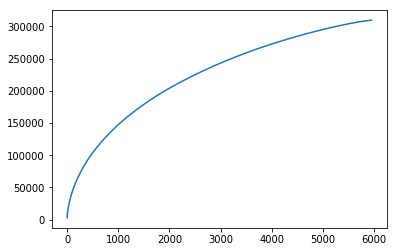

In [5]:
import matplotlib.pyplot as plt
df_infomap_friends = data['train']
print('nb_users: ',len(df_infomap_friends['user_id'].unique()))
print('nb_communities: ',len(df_infomap_friends['infomap_friends'].unique()))

plt.plot(np.cumsum(sorted(df_infomap_friends.groupby(by='infomap_friends').count()['user_id'].values, reverse = True)))

### Features

In [ ]:
data['train']

In [ ]:
data['train']['date'] = '2017-01-04'

In [ ]:
df_reviews_ = data['train'].loc[data['train']['has_reviewed'] == 1]
df_reviews_.head()

In [ ]:
communities = data['train'].set_index('user_id')['infomap_friends'].to_dict()

In [ ]:
data['train'] = compute_community_related_features(
    df_reviews_, 
    communities,
    min_community_size = 3, 
    min_community_visitors=1)

data['train'].drop('date', axis=1, inplace=True)

In [ ]:
a = 'azerty'
a['a']

In [ ]:
df_reviews_['community'] = df_reviews_.user_id.apply(lambda user: communities[user])

In [ ]:
g_bipartite = make_user_business_bipartite_graph(weighted=False, minimum_rating=4, igraph_=True)

print(g_bipartite.vs.attribute_names(),
g_bipartite.es.attribute_names())

In [ ]:
g_full = make_frienships_and_reviews_graph(weight_ratio=1, minimum_rating=0, igraph_=True)

print(g_full.vs.attribute_names(),
g_full.es.attribute_names())

### Small focus on coordinates

In [ ]:
coordinates = df_biz[['latitude', 'longitude']]
coordinates.plot.scatter('latitude','longitude')

In [ ]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=10)
clf.fit(coordinates)
coordinates_clusters = clf.labels_
plt.scatter(x = coordinates['latitude'], y = coordinates['longitude'], c=coordinates_clusters)

In [ ]:
a = [i for i in range(5) if i > 3]
a